In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("spam.csv")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.shape

(5572, 5)

In [4]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
df_1 = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1)

In [6]:
df_1.duplicated().sum()

403

In [7]:
df_1.drop_duplicates()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


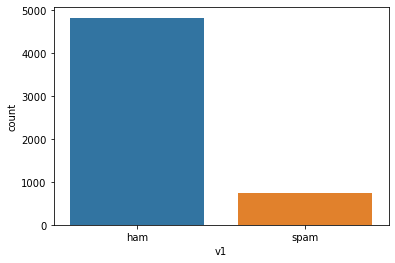

In [8]:
sns.countplot(x = 'v1',data = df_1)
plt.show()

In [9]:
df_1['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [10]:
df_1.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## CLEANING DATA

In [11]:
def text_process(df_1):
    df_1 =df_1.translate(str.maketrans('', '', string.punctuation))
    df_1 = [word for word in df_1.split() if word.lower() not in stopwords.words('english')]
    return " ".join(df_1)

In [12]:
spam_data = df_1[['v2','v1']]
spam_data.head()

,v2,v1
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [13]:
spam_data.columns = ['sentence','labels']
spam_data.head()

,sentence,labels
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [14]:
sentence = list(spam_data['sentence'])
label = list(spam_data['labels'])

In [15]:
from sklearn.preprocessing import LabelEncoder
encod = LabelEncoder()
encod.fit(label)

LabelEncoder()

In [16]:
encod.classes_

array(['ham', 'spam'], dtype='<U4')

In [17]:
import tensorflow as tf
from tensorflow import keras
def encoding(encod ,labels):
    transform = encod.transform(labels)
    encod = tf.keras.utils.to_categorical(transform)
    return encod
def decoding(encod,one_hot):
    transform = np.argmax(one_hot, axis = 1)
    decode = encod.inverse_transform(transform)
    return decode
    

## Splitting INTO Training and Testing

In [18]:
X = sentence
y = encoding(encod,label)

In [19]:
len(X), len(y)

(5572, 5572)

In [20]:
X_train = np.asarray(X[:5000])
y_train = np.asarray(y[:5000])

X_test = np.asarray(X[5000:])
y_test = np.asarray(y[5000:])

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000,), (5000, 2), (572,), (572, 2))

In [22]:
import tensorflow_hub as hub


In [23]:
# using universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
embed  = hub.load(module_url)


In [24]:
### testing the universal embdding 
embedding = embed([
                     "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"
])

print(embedding)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.016075   ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.05080861 -0.01652429  0.0157378  ...  0.00976658  0.03170122
   0.01788118]], shape=(2, 512), dtype=float32)


In [34]:
def embedding_func(x):
    embedding = embed(tf.squeeze(tf.cast(x,tf.string)))
    return embedding

## BUILDING THE MODEL

In [35]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype = tf.string)
embedding = layers.Lambda(embedding_func, output_shape = (512,))(inputs)
x = layers.Dense(256, activation = "relu")(embedding)
outputs = layers.Dense(2, activation = "softmax")(x)

model = tf.keras.Model(inputs, outputs)

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


## Compiling the Model

In [38]:
model.compile(loss = 'categorical_crossentropy',optimizer ='adam', metrics=['accuracy'])

In [40]:
# fitting data to the model

model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 5,
          )

Epoch 1/5


C:\Users\Shoaib\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Reshape:0", shape=(None, 320), dtype=float32), dense_shape=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


40/40 [==============================] - 10s 153ms/step - loss: 0.3387 - accuracy: 0.8890
Epoch 2/5
40/40 [==============================] - 1s 29ms/step - loss: 0.0917 - accuracy: 0.9774
Epoch 3/5
40/40 [==============================] - 1s 26ms/step - loss: 0.0578 - accuracy: 0.9844
Epoch 4/5
40/40 [==============================] - 1s 26ms/step - loss: 0.0462 - accuracy: 0.9872
Epoch 5/5
40/40 [==============================] - 1s 24ms/step - loss: 0.0396 - accuracy: 0.9888


In [41]:
model.evaluate(X_test,y_test)

18/18 [==============================] - 2s 20ms/step - loss: 0.0362 - accuracy: 0.9825


[0.0361747108399868, 0.9825174808502197]

In [46]:
pred = model.predict(X_test)
y_pred= decoding(encod,pred)

In [48]:
y_test_decode = decoding(encod, y_test)


In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
cm = confusion_matrix(y_test_decode, y_pred)
cm

array([[494,   4],
       [  6,  68]], dtype=int64)

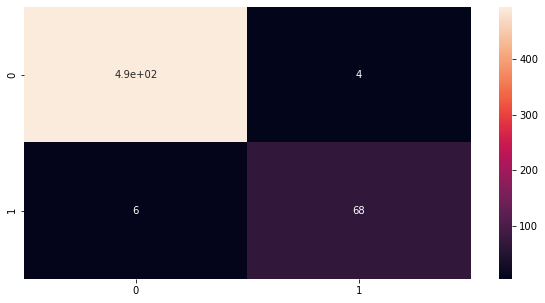

In [51]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(cm , annot=True)
plt.show()